<a href="https://colab.research.google.com/github/GonzaloPerezGomez/Pytorch/blob/main/03_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## 0. Computer vision libaries

* torchvision - base domain library for PyTorch computer vision
* torchvision.datasets - Datasets and DataLoading funtions for cumputer vision
* torchvision.models - get pretrained computer vision models
* torchvision.transforms - functions for manipulating your vision data to be suitable for use with ML model
+ torch.utils.data.Dataset - Base dataset class ofr Pytorch
* torch.util.data.DataLoader - Creates a Python iterable over a dataset

In [1]:
# Import PyTorch
import torch
from torch import nn

# Improt torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

## 1. Getting a Dataset

FashionMNIST

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(root="data", # Whare to download data to
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                  )

test_data = datasets.FashionMNIST(root="data", # Whare to download data to
                                   train=False,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                  )

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.3MB/s]


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
 # Color_Channel (black and white), Height, Width
train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 9)

### 1.3 Visualizing out data

torch.Size([28, 28])

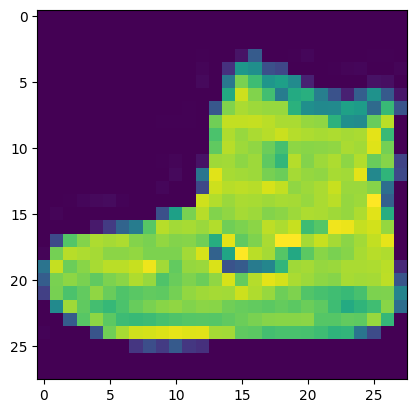

In [6]:
image, label = train_data[0]
plt.imshow(image.transpose(0, 2).transpose(0, 1)) # plt.imshow expects (Height, Width, Color_Cannel)
#plt.imshow(image.squeeze()) becuase the image is in black and white (Color_Channel = 1) we can algo get reed of the extra dimension
image.squeeze().shape

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

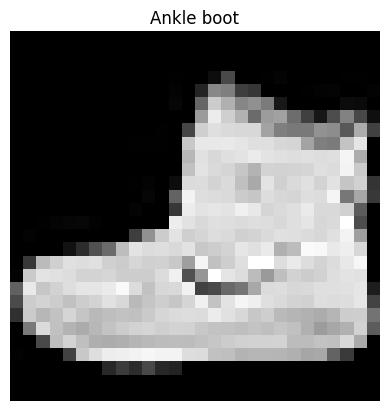

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 2. Prepare DataLoader

Our data is in the form of PyTorch Datasets. We want to turn it into Python iterable

Also we want to devide it in batches, so we can handle de data in "blocks"

In [8]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [9]:
# Lets check out what we`ve created
print(f"Legth of train_dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Legth of train_dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")


Legth of train_dataloader: 1875 batches of 32
Legth of train_dataloader: 313 batches of 32


In [10]:
# Whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

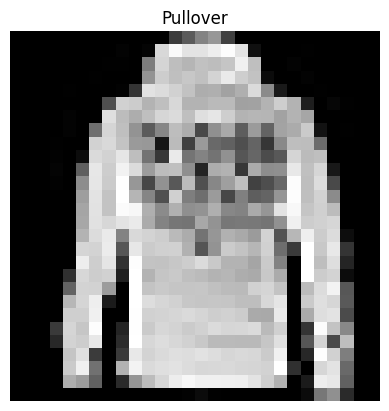

In [11]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 3. Model 0: Build a baseline model

In [12]:
#Create a flatten layer
flatten_model = nn.Flatten()

#Get a single sample
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [13]:
# Flatten de sample
output = flatten_model(x)
output.shape

torch.Size([1, 784])

In [14]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features=input_shape,
                  out_features=hidden_unit),

        nn.Linear(in_features=hidden_unit,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [15]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28*28
    hidden_unit=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - multi-class data so nn.CrossEntropyLoss()
* Optimizer - toch.optim.SGD
* Evaluation - classification problem, so accuracy

In [17]:
import requests
from pathlib import Path

# Download helper funtion from Lean PyTorch
if not Path("help_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("help_functions.py", "wb") as f:
    f.write(request.content)

from help_functions import plot_predictions, plot_decision_boundary, accuracy_fn

In [18]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

### 3.2 Creating a function to time our experiments

In [19]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  total_time= end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [20]:
start_time = timer()

end_time = timer()
print_train_time(start_time, end_time)

Train time on None: 0.000 seconds


5.100300001004143e-05

### 3.3 Train loop in batches of data

1. Loop through epochs
2. Loop through batchs, perform training steps, calculate the train loss *per batch*
3. Loop through batchs, perform testing steps, calculate the test loss *per batch*
4. Print what´s happening
5. Time it all

In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

# Create the train loop
for epoch in tqdm(range(epochs)):
  ### Train
  train_loss = 0

  print(f"Epoch: {epoch} \n-------------------")
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):

    model_0.train()
    # Forward pass
    y_pred = model_0(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loos backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloades
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  # Print out
  print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc {test_acc:.2f}%")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            str(next(model_0.parameters()).device))






  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.5904 | Test Loss: 0.5095 | Test Acc 82.04%
Epoch: 1 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4763 | Test Loss: 0.4799 | Test Acc 83.20%
Epoch: 2 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4550 | Test Loss: 0.4766 | Test Acc 83.43%
Train time on cpu: 31.165 seconds


## 4. Make prediction and get Model 0 results

In [22]:

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=None):

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss += loss_fn(y_pred, y)

      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {f"model_name": model.__class__.__name__,
          f"model_loss": loss.item(),
          f"model_acc": acc}

# Calculate model = results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results



{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic code

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

In [24]:
# Create a model with linear and not linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)
model_1 = FashionMNISTModelV1(784, 10, len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### 6.1 Setup loss, optimizer and evaluation metrics

In [25]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

In [26]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  ### Train
  train_loss, train_acc = 0, 0
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data in target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss and accuraty
    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y, y_pred.argmax(dim=1))
    train_acc += acc

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loos backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")



In [27]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()

  with torch.inference_mode():

    for X_test, y_test in data_loader:
      # Send data to target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Make predictions
      test_pred = model(X_test)

      # Calculate the loss and accuracy
      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    # Adjust the accuracy
    test_loss /= len(data_loader)

    test_acc /= len(data_loader)

  # Print out
  print(f"\nTest Loss: {test_loss:.4f} | Test Acc {test_acc:.2f}%")

### 6.3 Train and test with functions

In [28]:
epochs = 3
torch.manual_seed(42)
train_time_start_on_gpu = timer()

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch} \n-----------")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-----------
Train Loss: 1.09199 | Train Acc: 61.34%

Test Loss: 0.9273 | Test Acc 66.00%
Epoch: 1 
-----------
Train Loss: 0.73779 | Train Acc: 73.69%

Test Loss: 0.6879 | Test Acc 75.43%
Epoch: 2 
-----------
Train Loss: 0.66776 | Train Acc: 76.08%

Test Loss: 0.6433 | Test Acc 76.87%
Train time on cpu: 50.357 seconds


In [29]:
total_train_time_model_0

31.165199107000007

In [30]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6874349117279053,
 'model_acc': 75.65894568690096}

In [31]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 7. Model 2: Convolutional Neural Netword (CNN)

Very good at finding patterns in visual data

In [32]:
# Create CNN
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG model from CNN explainer website
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 49, # there`s a trick to calculate this
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    #print(f"Shape after conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Shape after conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape after classifier: {x.shape}")
    return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # Only one color channel
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [33]:
result = model_2(image.unsqueeze(0).to(device))
result

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], grad_fn=<AddmmBackward0>)

(<matplotlib.image.AxesImage at 0x79a12c9e2a10>, torch.Size([1, 28, 28]))

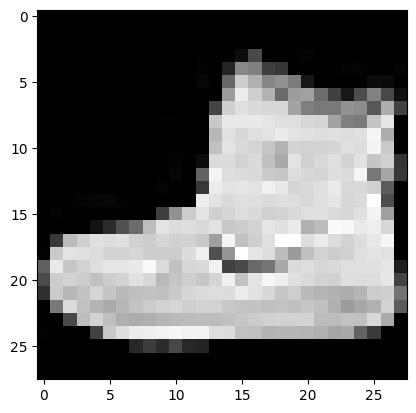

In [34]:
plt.imshow(image.squeeze(), cmap="gray"), image.shape

### 7.1 Stepping through nn.Conv2d

In [35]:
torch.manual_seed(42)

# Create a batch of images
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [36]:
torch.manual_seed(42)
# Create a single Conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through nn.MaxPool2d

In [37]:
# Try with the test image
test_image.shape, test_image.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [38]:
# Create max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through conv_layer
test_image_conv = conv_layer(test_image)
print(test_image_conv.shape)

# Pass through max pool layer
test_image_conv_max = max_pool_layer(test_image_conv)
print(test_image_conv_max.shape)

torch.Size([10, 62, 62])
torch.Size([10, 31, 31])


In [39]:
torch.manual_seed(42)
random = torch.rand(size=(1,1,2,2))
print(random)

max_pool_layer_1 = nn.MaxPool2d(kernel_size=2)
random_max = max_pool_layer_1(random)
print(random_max, random_max.shape)

tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])
tensor([[[[0.9593]]]]) torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for model_2

In [40]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.1)

### 7.4 Use functions for train and test

In [41]:
epochs = 3
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model_2 = timer()

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n--------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.59518 | Train Acc: 78.38%

Test Loss: 0.3950 | Test Acc 85.99%
Epoch: 1
--------
Train Loss: 0.36536 | Train Acc: 86.90%

Test Loss: 0.3524 | Test Acc 86.91%
Epoch: 2
--------
Train Loss: 0.32588 | Train Acc: 88.13%

Test Loss: 0.3272 | Test Acc 88.07%
Train time on cpu: 160.594 seconds


In [42]:
model_2_results = eval_model(model_2, train_dataloader, loss_fn, accuracy_fn, device)
print(model_0_results, "\n", model_1_results, "\n", model_2_results)

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499} 
 {'model_name': 'FashionMNISTModelV1', 'model_loss': 0.6874349117279053, 'model_acc': 75.65894568690096} 
 {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.29783254861831665, 'model_acc': 89.55166666666666}


## 8. Compare model results and training time


In [43]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.687435,75.658946
2,FashionMNISTModelV2,0.297833,89.551667


In [44]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,31.165199
1,FashionMNISTModelV1,0.687435,75.658946,50.356719
2,FashionMNISTModelV2,0.297833,89.551667,160.594420


Text(0, 0.5, 'model')

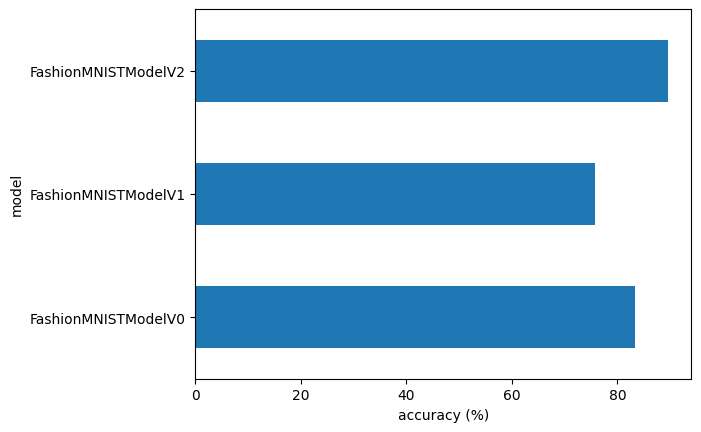

In [45]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions with the best model

In [46]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [47]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [48]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View
pred_probs[:2]

tensor([[3.6430e-04, 1.1928e-05, 1.2444e-02, 1.3549e-05, 9.7195e-01, 1.4851e-06,
         1.5109e-02, 1.4409e-06, 9.2698e-05, 9.6366e-06],
        [9.3214e-03, 9.1156e-05, 9.1314e-01, 4.3617e-04, 4.5389e-02, 1.9679e-05,
         3.1503e-02, 9.8588e-06, 4.0151e-05, 4.5730e-05]])

In [49]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes[:2]

tensor([4, 2])

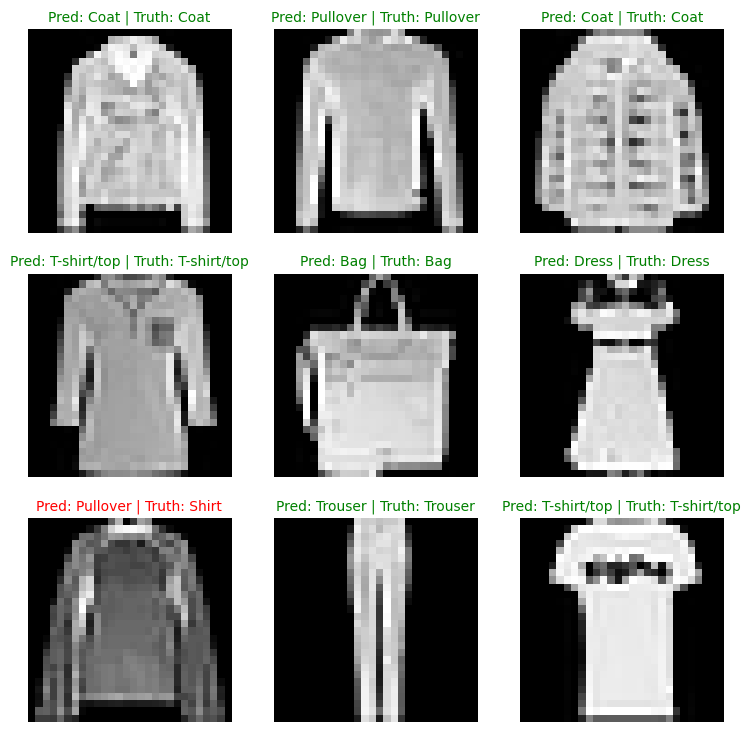

In [50]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## 10. Make a confusion matrix

1. Make predictions on test dataset
2. Make a ConfusionMatrix `torchmetrics`
3. Plot the confusion matrix

In [51]:
from tqdm.auto import tqdm

# Make predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):

    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [52]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
mlxtend version: 0.23.4


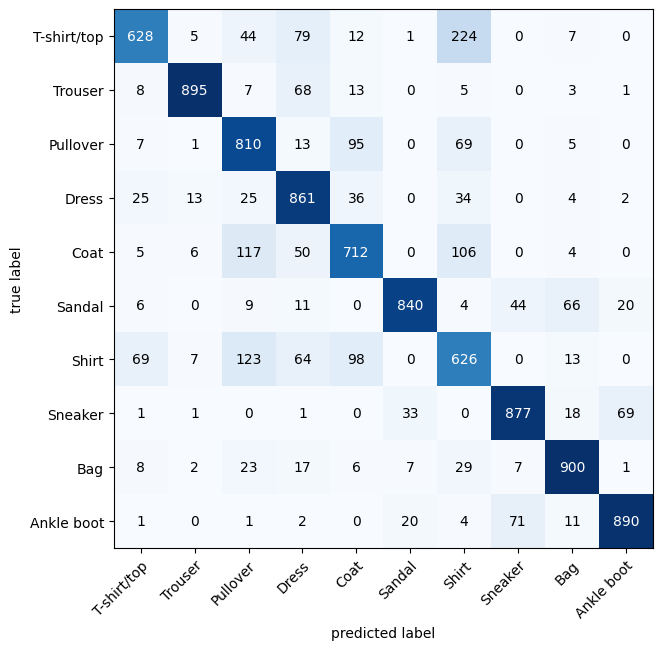

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion metrics and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass").to(device)
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets.to(device))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

## 11. Saving and Loading our best model

In [63]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

In [64]:
# Create a new instance
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names)).to(device)

# Load in the state dict
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [66]:
# Evaluate the loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

print(f"Original results: {model_2_results}")
print(f"Loaded model results: {loaded_model_2_results}")

Original results: {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.29783254861831665, 'model_acc': 89.55166666666666}
Loaded model results: {'model_name': 'FashionMNISTModelV2', 'model_loss': 0.32718968391418457, 'model_acc': 88.06908945686901}
